# Deep Neural Network for Image Classification: Application

When you finish this, you will have finished the last programming assignment of Week 4, and also the last programming assignment of this course! 

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

print("Packages loaded successfully!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Packages loaded successfully!


## 2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [6]:
#reshape and standardize
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255
test_x = test_x_flatten/255

In [7]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [8]:
#layer dimenshions
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [9]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    #initialize the parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    #get the parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #loop (gradient descent)
    
    for i in range(0, num_iterations):
        
        #forward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        #compute cost
        cost = compute_cost(A2, Y)
        
        #initialize back prop
        dA2 = -(np.divide(Y, A2) - np.divide(1-Y, 1-A2))
        
        #backprop
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
            
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
        
        

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366413
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.1985073503746608
Cost after iteration 1500: 0.17448318112556635
Cost after iteration 1600: 0.17080762978097128
Cost after iteration 1700: 0.11306524562164709
Cost after iteration 1800: 0.09629426845937158
Cost after iteration 1900: 0.08342617959726872
Cost after iteration 2000: 0.07439078704319091
Cost after iteration 2100: 0.066307481

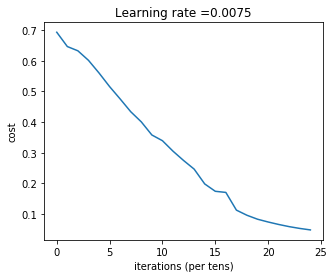

In [10]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500)

In [11]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [12]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [13]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [14]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        
        #forward prop
        AL, caches = L_model_forward(X, parameters)
        
        #cost compute
        cost = compute_cost(AL, Y)
        
        #back prop
        grads = L_model_backward(AL, Y, caches)
        
        #update parameters
        paramteters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


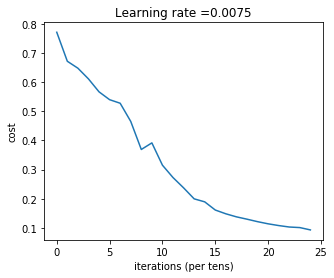

In [16]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500)

/home/rahul/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/home/rahul/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


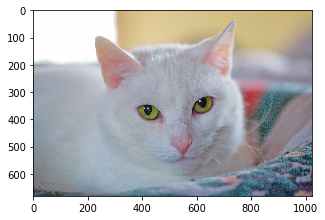

In [17]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")